In [1]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy     : 1.20.3
scipy     : 1.7.1
sklearn   : 0.0.post5
pandas    : 1.3.4
matplotlib: 3.4.3



목표 : 캘리포니아 인구조사 데이터를 사용해 이 지역의 주택 가격 모델을 만드는 것

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 데이터 다운로드

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path): #디렉토리 존재 여부
        os.makedirs(housing_path) #디렉토리 생성
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

데이터 읽기

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    print(csv_path)
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

datasets\housing\housing.csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


캘리포니아 인구조사 데이터 정보  
population 인구, median income 중간 소득, median housing price 중간 주택 가격 등을 담고있다.

In [7]:
housing.info() 
#info 메서드는 데이터의 간략한 설명과 전체 행 수, 
#각 특성의 타입과 널이 아닌 값의 개수를 확인하는데 좋다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# ocean_proximity 값만 타입이 다르다. 데이터 살펴보기.
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# describe() 메서드는 숫자형 특성의 요약 정보를 보여준다.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


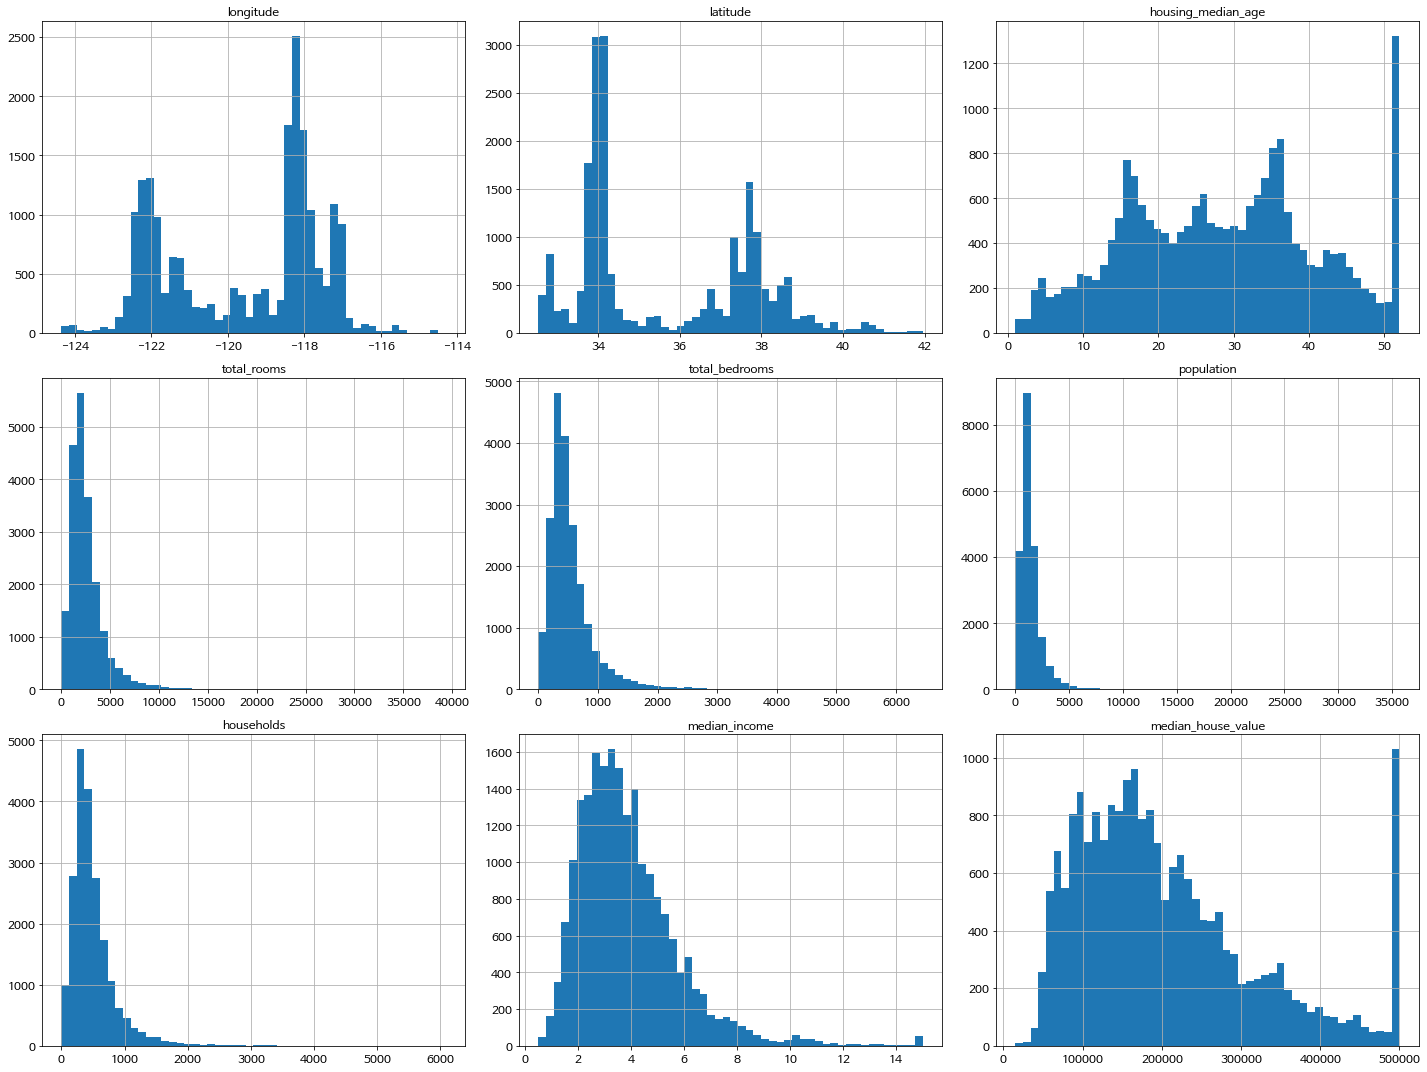

In [10]:
# 데이터의 형태를 빠르게 검토하는 다른 방법은 히스토그램으로 그려보는 것이다.

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize =(20,15))
save_fig('attribute_hisogram_plots')
plt.show()

In [11]:
#일관된 출력을 위해 유사난추 초기화
np.random.seed(42)

무작위로 데이터셋의 20%를 테스트 세트로 한다.

In [12]:
import numpy as np

# 예시를 위해서 만든 것입니다. 사이킷런에는 train_test_split() 함수가 있습니다.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


다음 업데이트된 데이터셋을 사용하면 데이터셋이 바뀌어 문제가 된다.
해시값을 계산하여 해시의 마지막 바이트 값이 51(256의 20% 정도) 보다 작거나 같은 샘플만 테스트 세트로 보낼 수 있다.
이렇게 하면 데이터셋이 갱신되더라도 테스트 세트가 동일하게 유지할 수 있다.

In [14]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids=data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

주택 데이터셋에는 식별자 컬럼이 없다.  
대신 행의 인덱스 ID를 사용하면 된다.

In [15]:
housing_with_id = housing.reset_index() #'index'열이 추가된 데이터프레임이 반환된다.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
print(len(train_set), 'train +', len(test_set),'test')

16512 train + 4128 test


만약 인덱스를 고요 식별자로 사용하기 힘들때, 구역의 위도와 경도같이 몇백 년 후까지 안정적이라고 보장할 수 있는 특성을 식별자로 만들 수 있다.  
(위치 정보는 겹칠 수 있어서 원치 않는 샘플링 편향을 만들 수 있다.)

In [16]:
housing_with_id['id'] = housing['longitude']* 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')
print(len(train_set), 'train +', len(test_set),'test')
test_set.head()

16322 train + 4318 test


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


사이킷런의 train_test_split  
앞에서 만든 train_test_split와 비슷하지만 난수값을 지정할 수 있는 random_state 매개변수가 있고, 행의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있다.

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), 'train +', len(test_set),'test')
test_set.head()

16512 train + 4128 test


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


중간 소득 대부분이 `$20,000 ~ $50,000`사이에 있고 일부는 `$60,000`를 넘기도 한다.  
계층별로 데이터 셋에 충분한 샘플 수가 있어야 한다. 그렇지 않으면 계층의 중요도를 추정하는데 편향이 발생할 수 있다.

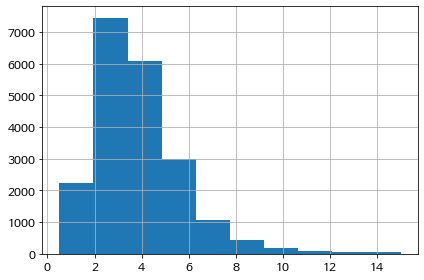

In [18]:
housing['median_income'].hist()
save_fig('median_income_hisogram_plots')
plt.show()

In [19]:
# 소득 카테고리 새수를 제한하기 위해 1.5로 나눈다.
housing['income_cat']= np.ceil(housing['median_income']/1.5)

# 5이상은 5로 레이블
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [20]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

소득 카테고리의 히스토그램

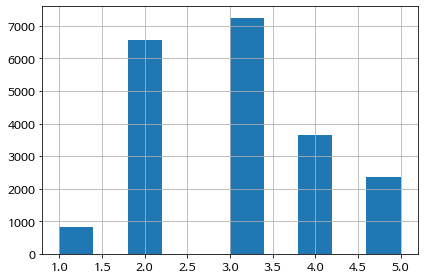

In [21]:
housing['income_cat'].hist()
save_fig('income_category_hist')
plt.show()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
housing['income_cat'].value_counts() /len(housing) 
#전 주택 데이터셋에서 소득 카테고리의 비율

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [24]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "전체": income_cat_proportions(housing),
    "무작위 샘플링": income_cat_proportions(test_set),
    "계층 샘플링": income_cat_proportions(strat_test_set),
}).sort_index()
compare_props["무작위 샘플링 오류율"] = 100 * compare_props["무작위 샘플링"] / compare_props["전체"] - 100
compare_props["계층 샘플링 오류율"] = 100 * compare_props["계층 샘플링"] / compare_props["전체"] - 100

계층 샘플링이 전체 샘플링의 비율과 비슷하다.  
무작위 샘플링은 많이 다르다.

In [25]:
compare_props

,전체,무작위 샘플링,계층 샘플링,무작위 샘플링 오류율,계층 샘플링 오류율
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


데이터 원상복구

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화 

훈련 세트를 손상하지 않기 위해 복사본을 사용.

In [27]:
housing = strat_train_set.copy()

## 지리적 데이터 시각화 

지리 정보(위도 경도)가 있으니 산점도로 만들어 데이터를 시각화 하는것이 좋다.

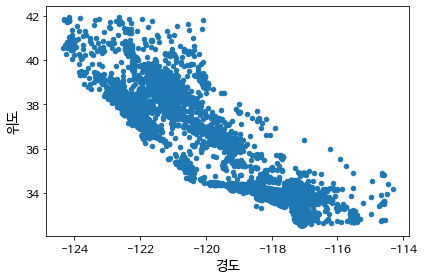

In [28]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude')
ax.set(xlabel='경도', ylabel='위도')
save_fig('bad_visualization_plot')

캘리포니아 지역은 잘 나타내지만 어떤 특별한 패턴을 찾기가 힘들다.  
alpah옵션을 0.1로 줘 밀집된 영역을 확인할 수 있다.

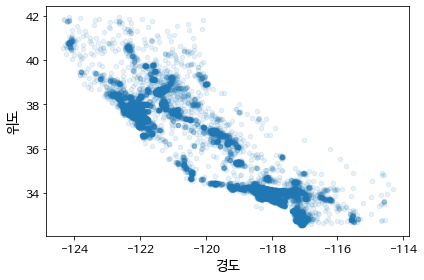

In [29]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
ax.set(xlabel='경도', ylabel='위도')
save_fig('better_visualization_plot')

s: 원의 반지름(구역의 인구)  
c: 색깔(가격)  
cmap: 컬러 맵(파란색 낮은가격, 빨간색 높은가격)

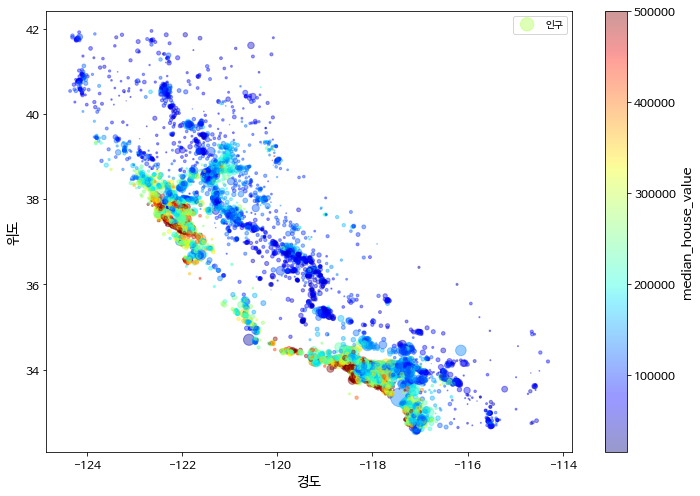

In [30]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
                 s=housing['population']/100, label='인구', figsize=(10,7),
                 c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
                 sharex=False)
ax.set(xlabel='경도', ylabel='위도')
plt.legend()
save_fig('housing_prices_scatterplot')

해안가 근처 인구 밀집 지역의 주택가격이 높다고 생각됨.

C:\Users\mangg\AppData\Local\Temp/ipykernel_20316/210605042.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)


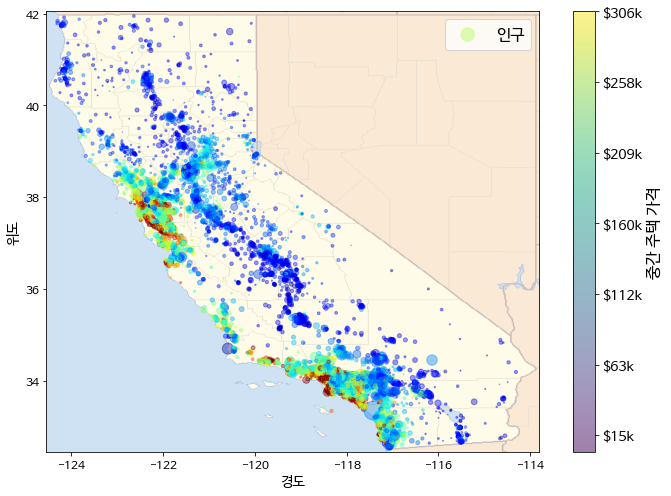

In [31]:
import matplotlib.image as mpimg
california_img = mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,7),
                 s=housing['population']/100, label='인구',
                 c='median_house_value', cmap=plt.get_cmap('jet'),
                 colorbar=False, alpha=0.4)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel('위도',fontsize=14)
plt.xlabel('경도', fontsize=14)

prices = housing['median_house_value']
tick_values=np.linspace(prices.min(), prices.max(), 11)
cbar=plt.colorbar()
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('중간 주택 가격', fontsize=16)

plt.legend(fontsize=16)
save_fig('california_housing_prices_plot')
plt.show()

## 상관관계 조사
데이터셋이 크지 않으므로 모든 특성 간의 **표준 상관계수(피어슨 상관계수)**를 corr() 메서드를 사용해 계산.

In [32]:
corr_matrix=housing.corr()

중간 주택 가격과 다른 특성 사이의 상관관계

In [33]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

상관관계의 범위는 -1~1이다. 1에 가까우면 강한 양의 상관관계를 가진다는 뜻이다.  
예를 들어 중간 주택 가격은 중간 소득이 올라갈 때 증가하는 경향이 있다고 볼 수 있다.  
계수가 0에 가까우면 선형적인 상관관계가 없다는 뜻이다.

숫자형 특성 사이에 산점도를 그려주는 판다스의 scatter_matrix 함수  
특성이 11개이므로 총 $11^2 = 121$개의 그래프가 되어 상관관계 높아 보이는 특성 몇 개만 비교.

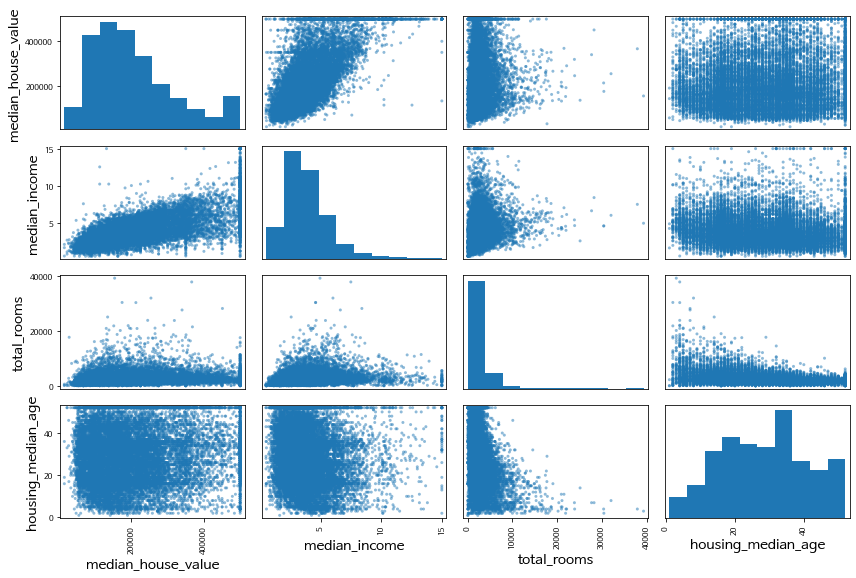

In [34]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
save_fig('scatter_matrix_plot')

중간 주택 가격을 예측하는 데 가장 유용할 것 같은 특성은 중간 소득이다.  

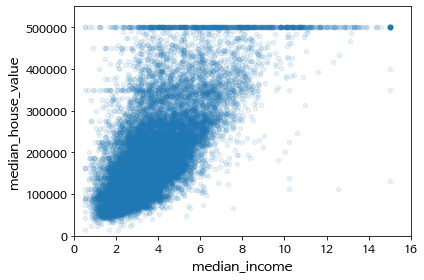

In [35]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig('income_vs_house_value_scatterplot')

상관관계가 매우 강하다. 위쪽으로 향하는 경향이 보인다.  
\\$450,000, \\$350,000, $280,000 등 직선에 가까운 형태가 보인다.  
이러한 해당 구역을 제거하는 것이 좋다.

## 특성 조합으로 실험 

In [36]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households'] #가구당 방 개수
housing['bedrooms_per_room']= housing['total_bedrooms']/housing['total_rooms'] #방당 침대수
housing['population_per_household'] = housing['population']/housing['households'] #가구당 인원수

In [37]:
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

bedrooms_per_room 특성은 전체 방 개수나 침대 개수보다 중간 주택 가격과의 상관관계가 훨씬 높다.  
침대/방의 비율이 낮은 집은 더 비싼 경향이 있다. 가구당 방 개수도 구역 내 전체 방 개수보다 더 유용하다.

<function matplotlib.pyplot.show(close=None, block=None)>

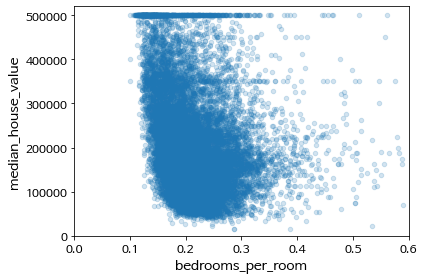

In [38]:
housing.plot(kind='scatter',x='bedrooms_per_room', y='median_house_value',alpha=0.2)
plt.axis([0,0.6,0,520000])
save_fig('bedrooms_per_room_vs_house_value_scatterplot')
plt.show

In [39]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# 머신러닝 알고리즘을 위한 데이터 준비

머신러닝 알고리즘을 위해 데이터를 준비할 때 함수를 만들어 자동화해야 하는 이유.  
- 데이터 변환을 손쉽게 반복할 수 있다.
- 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
- 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는 데 이 함수를 이용할 수 있다.
- 여러 가지 데이터 변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는데 편리하다.

원래 훈련 세트를 복원하고, 예측 변수와 타깃 값에 같은 변형을 적용하지 않기 위해 예측 변수와 레이블을 분리한다.(drop()은 데이터 복사본을 만들며 원본에 영향을 주지 않는다.)

In [40]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

## 데이터 정제 

데이터 특성에 값이 없는경우 고치는 방법
- 해당 구역을 제거한다.
- 전체 특성을 삭제한다.
- 어떤 값으로 채운다(0, 평균, 중간값 등).

In [41]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [42]:
sample_incomplete_rows.dropna(subset=['total_bedrooms']) #방법 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [43]:
sample_incomplete_rows.drop('total_bedrooms', axis=1) #방법 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [44]:
median =housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True) #방법 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


 사이킷런의 SimpleImputer는 누락된 값을 손쉽게 다루도록 해준다.

In [69]:
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(strategy='median')

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제한다.

In [70]:
housing_num=housing.drop('ocean_proximity',axis=1)
# 다른 방법 : housing_num = housing.select_dtype(include=[np.number])

In [71]:
Imputer.fit(housing_num)

SimpleImputer(strategy='median')

imputer는 각 특성의 중간값을 계산해서 그 결과를 statistics_ 속성에 저장한다.

In [72]:
Imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인

In [73]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

훈련 세트에 누락된 값을 중간값으로 변환.

In [74]:
X = Imputer.transform(housing_num) #넘파이 배열이다

In [75]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index= list(housing.index.values))

누락값에 중간값이 잘 들어갔다.

In [76]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [77]:
Imputer.strategy

'median'

In [78]:
housing_tr=pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## 텍스트와 범주형 특성 다루기

In [79]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

판다스의 factorize() 메소드는 문자열 범주형 특성을 숫자 범주형 특성으로 변환시켜 준다.

In [80]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [81]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

한 특성만 1이고(핫) 나머지는 0으로 만드는 원-핫 인코딩을 한다.  
사이킷런은 숫자로 된 범주형 값을 원-핫 벡터로 바꿔주는 `OneHotEncoer`를 제공한다.

>사이킷런 0.20 버전에서 OneHotEncoder의 동작 방식이 변경되었습니다. 종전에는 0~최댓값 사이의 정수를 카테고리로 인식했지만 앞으로는 정수나 문자열에 상관없이 고유한 값만을 카테고리로 인식합니다. 경고 메세지를 피하기 위해 categories 매개변수를 auto로 설정합니다.

In [82]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
# housing_cat_encoded가 1차배열이므로 구조를 바꾼다. -1은 차원을 지정하지 않는다.
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

OneHotEncoder는 기본적으로 희소 행렬을 반환한다.  
(밀집된) 넘파이 배열로 바꾸려면 toarray() 메소드를 사용한다.

In [83]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## 나만의 변환기
p.105 책 확인.

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

# 컬럼 인덱스
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [85]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
2,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


## 변환 파이프라인
사이킷런에 연속된 변환을 순서대로 처리할 수 있도록 도와주는 Pipeline 클래스가 있다.  
다음은 숫자 특성을 처리하는 간단한 파이프라인이다.

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #strategy 결측치를 대채할 값
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()), #평균0 분산1으로 조정/ 표준화
    ])
    
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [107]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

마지막 단계에는 변환기와 추정기를 모두 사용할 수 있고 그 외에는 모두 변환기여야 한다. fit_transform() 메서드 사용.

### future_encoders.py를 사용한 방법=====================================================
사이킷런의 0.20 버전에 포함될 `ColumnTransformer`를 사용하면 책의 예제에서처럼 `DataFrameSelector`와 `FeatureUnion`을 사용하지 않고 간단히 전체 파이프라인을 만들 수 있습니다. 아직 사이킷런 0.20 버전이 릴리스되기 전이므로 여기서는 future_encoders.py에 `ColumnTransformer`를 넣어 놓고 사용합니다.

사이킷런 0.20 버전에 추가된 `sklearn.compose.ColumnTransformer`로 코드를 변경합니다.

In [108]:
# from future_encoders import ColumnTransformer
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(categories='auto'), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### ====================================================

판다스의 DataFrame 컬럼의 일부를 선택하는 변환기.  
사이킷런이 DataFrame을 바로 사요하지 못하므로 수치형이나 범주형 컬럼을 선택하는 클래스를 만든다.

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

DataFrameSelector는 나머지는 버리고 필요한 특성을 선택하여 데이터프레임을 넘파이 배열로 바꾸는 식으로 데이터를 변환한다.  
이를 이용해 데이터프레임을 받아 수치형만 다루는 파이프라인을 손쉽게 만들 수 있다.

In [94]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

CategoricalEncoder

In [98]:
# [PR #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)에서 가져온 CategoricalEncoder 클래스의 정의.
# 이 클래스는 사이킷런 0.20에 포함될 예정입니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [106]:
cat_papeline= Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

### future_encoders.py를 사용한 방법 ==================================================

In [109]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(categories='auto', sparse=False)),
    ])

### ====================================================

두 파이프라인 합치기

In [110]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [111]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [112]:
housing_prepared.shape

(16512, 16)

# 모델 선택과 훈련

## 훈련 세트에서 훈련하고 평가하기
선형 회귀 모델 만들기

In [114]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [117]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측:", lin_reg.predict(some_data_prepared))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [118]:
print("레이블:", list(some_labels))

레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


예측이 40% 가까이 벗어났다.

**RMSE(평균 제곰근 오차: 실제 값과 예측한 값의 사이의 평균 차이)**를 측정

In [148]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

중간 주택가격은 \\$120,000 ~ \\$265,000 이다.  
예측 오차가 $68.628인 것은 만족스럽지 못한다.  
이는 모델이 훈련 데이터에 과소적합된 사례이다.  
충분한 정보를 제공하지 못했거나 모델이 충분히 강력하지 못한다는 뜻이다.  
과소적합을 해결하는 방법은 더 강력한 모델을 선택하거나 훈련 알고리즘에 더 좋은 특성을 주입하거나 모델의 규제를 감소시키는 것이다.  

In [149]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

DecisionTreeRegressor를 훈련시켜보겠다. 이 모델은 더 강력하고 데이터에서 복잡한 비선형 관계를 찾을 수 있다.

In [150]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [151]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

심하게 과대적합된 것으로 보인다.

### 교차 검증을 사용한 평가

K-겹 교차 검증(K-fold cross-validation)을 수행하여 교차검증을 한다.  
- 훈련 세트를 10개의 서브셋(폴드)으로 무작위 분할한다. 매번 1개의 폴드를 선택하여 나머지 9개 폴드는 훈련에 사용하여 10개의 평가 점수가 담긴 배열이 결과가 된다.

In [155]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [153]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [156]:
display_scores(tree_rmse_scores)

Scores: [70005.60762416 67808.02751299 71066.05630403 70539.78564163
 69972.030994   73920.89443999 71962.71024004 71098.10661975
 76520.28221954 68523.71432839]
Mean: 71141.72159245313
Standard deviation: 2415.0176434330247


In [158]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores= np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798347


결정 트리 모델보다 선형 회귀 모델이 성능이 더 좋아보인다.

RandomForestRegressor모델 : 특성을 무작위로 선택해서 많은 결정트리를 만들고 그 예측을 평균 내는 방식으로 작동한다. 여러 다른 모델을 모아서 하나의 모델을 만드는 것을 앙상블 학습이라하고 머신러닝 알고리즘의 성능을 극대화 하는 방법 중 하나이다.

In [160]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [161]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [163]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


앞선 모델보다 더 훌륭해 보이지만 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮으므로 여전히 훈련 세트에 과대적합되어 있다.  
과대적합의 해결 방법은 모델을 간단히 하거나, 제한하거나, 더 많은 훈련 데이터를 모으는 것이다.

In [164]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [165]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [105342.09141998 112489.24624123 110092.35042753 113403.22892482
 110638.90119657 115675.8320024  110703.56887243 114476.89008206
 113756.17971227 111520.1120808 ]
Mean: 111809.84009600841
Standard deviation: 2762.393664321567


# 모델 세부 튜닝

## 그리드 탐색
최적 하이퍼파라미터 조합 탐색

In [167]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    #하이퍼파라미터 12(3 X 4)개의 조합을 시도
    {'n_estimators': [3, 10, 30], 'max_features':[2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(2 X 3)개의 조합을 시도
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features':[ 2, 3, 4]}
]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 폴드에서 훈련하면 총(12+6)*5 = 90번의 훈련이 일어난다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

최상의 파라미터 조합

In [168]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

8과 30은 탐색 범위의 최댓값이기 때문에 계속 점수가 향상될 가능성이 있으므로 더 큰값으로 다시 검색해야 한다.

최적의 추정기에 직접 접근

In [169]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

평가 점수 확인

In [170]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

8과 30일 때 최적의 솔루션이다.

In [171]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.103837,0.009943,0.004496,0.000839,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.344305,0.014692,0.014600,0.003823,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,1.053681,0.041999,0.037794,0.004982,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.161690,0.002971,0.004902,0.000977,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.579960,0.031182,0.012491,0.001096,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.640668,0.107864,0.036998,0.003545,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.217938,0.020980,0.005193,0.000924,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.744008,0.057735,0.014423,0.003157,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,2.333958,0.144602,0.041451,0.009029,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.308202,0.035066,0.005300,0.001024,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## 랜덤 탐색
그리드 탐색 방법은 적은 수의 조합을 탐구할 때 좋다.  
탐색 공간이 커지면 RandomizedSearchCV를 사용하는 편이 더 좋다.

In [172]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015F2EB28220>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015F2EC604F0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [173]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


### 최상의 모델과 오차 분석
RandomForestRegressor가 정확한 예측을 만들기 위한 각 특성의 상대적인 중요도를 알려준다.

In [174]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

그에 대응하는 특성의 이름 표시

In [177]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_encoder = full_pipeline.named_transformers_["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

## 테스트 세트로 시스템 평가하기

In [182]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [183]:
final_rmse

47730.22690385927

테스트 RMSE에 대한 95% 신뢰구간

In [184]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

수동으로 계산하면

In [185]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

t검정 대신 z검정

In [186]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

# 추가 내용

## 전처리와 예측을 포함한 파이프라인

In [187]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Joblib을 사용한 모델 저장

In [188]:
my_model = full_pipeline_with_predictor

In [191]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

ImportError: cannot import name 'joblib' from 'sklearn.externals' (D:\Users\mangg\anaconda3\lib\site-packages\sklearn\externals\__init__.py)

## `RandomizedSearchCV`을 위한 Scipy 분포 함수

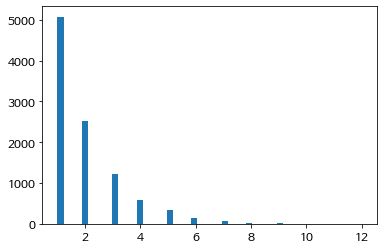

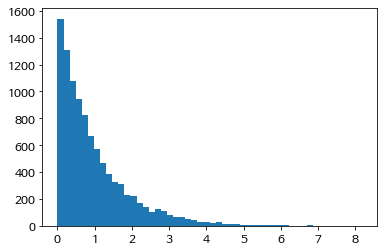

In [192]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()